Se analizaran los datos de Grupo Financiero Actinver.

In [1]:
import pywt, numpy as np
from keras.losses import mean_squared_error
import matplotlib.pyplot as plt
import src.utilerias.reader as rd
import src.utilerias.utilerias as utls
import src.utilerias.seniales.dwt.dwt_multinivel as m_dwt
from scipy.stats import ks_2samp

# Llamamos a la función para impiar la carpeta de logs antes de ejecutar el script
logs_dir = 'logs/DWT_LSTM/estandar'
logs_dir_auto_pred = 'logs/DWT_LSTM/auto_predictiva'
utls.eliminar_archivos_registro(logs_dir)
utls.eliminar_archivos_registro(logs_dir_auto_pred)

Longitud de la entrada: 415


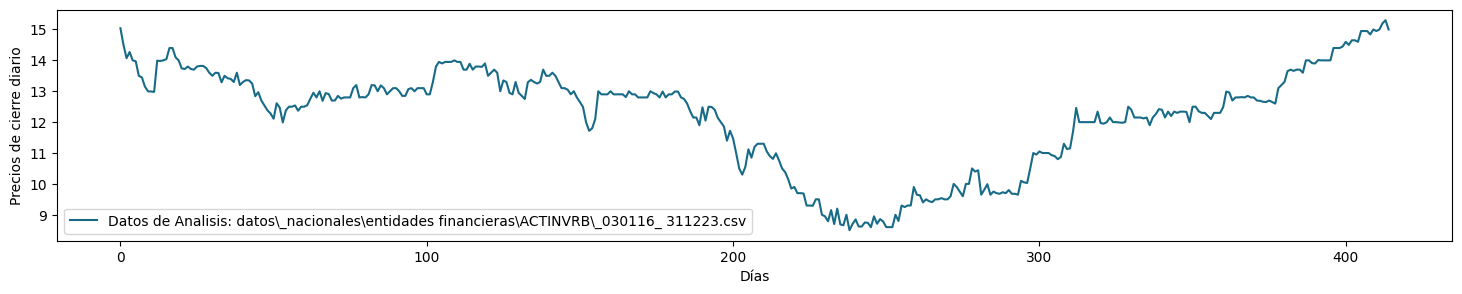

In [2]:
# Abrir el archivo CSV en modo lectura

# DATOS = 'cierre.csv'#Grupo Financiero Inbursa
# DATOS = 'Datos históricos COMI 03012016_27122020.csv' #Datos originales
# DATOS = 'datos/Datos históricos COMI 3ene16-31dic2020 semanal.csv' #Datos semanales
# DATOS = 'Datos históricos COMI_prueba 30jun19-31dic2020.csv' #Datos semanales de prueba
# DATOS = 'Datos históricos COMI3ene2016_27dic2020_diario.csv' #Datos originales diarios de prueba
# DATOS = 'Datos históricos COMI_prueba 30jun19-31dic2020_DIARIO.csv' #Datos diarios de prueba

# ACTINVRB
DATOS = 'datos\_nacionales\entidades financieras\ACTINVRB\_030116_ 311223.csv' 
# BOLSAA
# DATOS = 'datos\_nacionales\entidades financieras\BOLSAA\_030116_311223.csv'
# GBMO
#DATOS = 'datos\_nacionales\entidades financieras\GBMO\_030116_311223.csv'
# GENTERA
# DATOS = 'datos\_nacionales\entidades financieras\GENTERA\_030116_311223.csv'
# GFINBURO
# DATOS = 'datos\_nacionales\entidades financieras\GFINBURO\_030116_311223.csv'
# GFNORTEO
# DATOS = 'datos\_nacionales\entidades financieras\GFNORTEO\_030116_311223.csv'
# GNP
# DATOS = 'datos\_nacionales\entidades financieras\GNP\_030116_311223.csv'
# Q
#DATOS = 'datos\_nacionales\entidades financieras\Q\_030116_311223.csv'

cierre = rd.leer_archivo(DATOS)
#se convierten todos los valores a flotantes
cierre = cierre.astype(float)

# Crear un gráfico de línea con los valores de x, y
print(f"Longitud de la entrada: {len(cierre)}")
plt.figure(figsize=(18, 3))
plt.plot(cierre, label=f"Datos de Analisis: {DATOS}", color='#176B87')
plt.xlabel('Días')
plt.ylabel('Precios de cierre diario')
plt.legend()
plt.show()

# Eleccion de Ondícula Madre

Se elige las ondículas madre dependiendo de las características de la serie de tiempo que se va a análizar. Para series que impliquen cambios suaves y no repentinos es recomendable usar Haar ya que responde bien a estos cambios.

Se elige bior3.5 debido a las caracteristicas de las fluctuaciones entre periodos con altas cantidades de inversiones y periodos en los que no.

En general, debe de ser una funcion de las caracteristicas de la serie original para que esta pueda ser reconstruida o analizada.

Longitud de la entrada de cA: 213


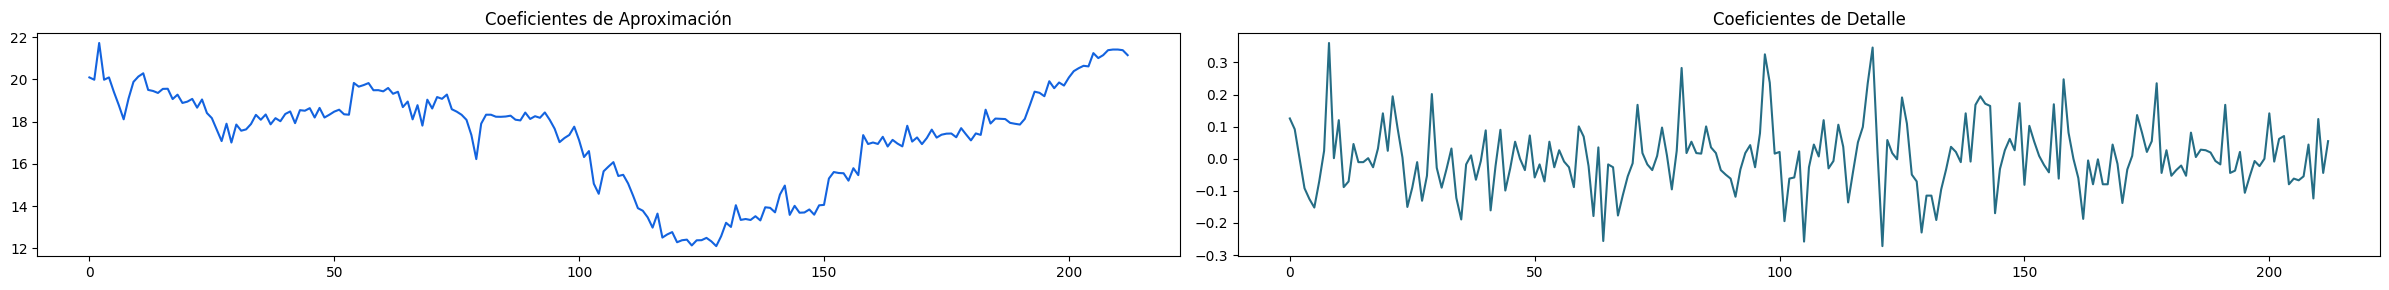

In [3]:
#Se descompone la lista de precios de cierre del intervalo mencionado anteriormente a partir de la dwt con la función bior3.5
# print(pywt.wavelist()) # imprime la lista de wavelets de la biblioteca
wavelet = 'bior3.5'
mode = pywt.Modes.symmetric #antireflect, smooth, constant
wavelet = pywt.Wavelet(wavelet)
(cA, cD) = pywt.dwt(cierre.tolist(), wavelet, mode=mode)
print(f"Longitud de la entrada de cA: {len(cA)}")

plt.figure(figsize=(24, 3))
aprox_coef = True
index = 1

for _ in [cA, cD]:
    plt.subplot(1, 2, index)
    plt.plot( _, color='#1363DF' if aprox_coef else '#256D85')
    plt.title('Coeficientes de Aproximación' if aprox_coef else 'Coeficientes de Detalle')
    aprox_coef = False
    index = index + 1

plt.tight_layout()
plt.show()

1. Se dividen los precios de cierre semanal en el conjunto de pruebas (70%) y un conjunto de pruebas (30%). Se realiza la separacion del conjunto de entrenamiento y el de prueba

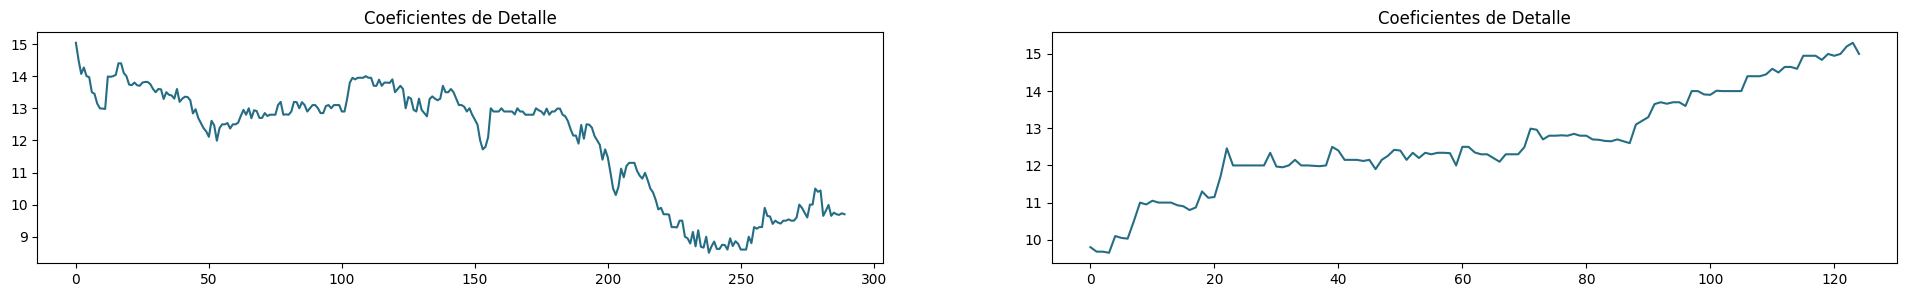

In [4]:
#Se realiza el proceso 5 veces
cierre_e = cierre[:int(len(cierre) * 0.7)]#cierre entrenamiento len 182
cierre_p = cierre[int(len(cierre) * 0.7):]#cierre prueba len 78

# # Muestreo aleatorio
# # Genera índices aleatorios únicos y ordenados
# indices_aleatorios = np.sort(np.random.choice(len(cierre), size=int(0.3 * len(cierre)) + 8, replace=False))
# # Selecciona los elementos correspondientes a los índices ordenados
# cierre_p = cierre[indices_aleatorios]
# # Calcula los índices del 70% restante (complemento del conjunto del 30%)
# indices_restantes = np.setdiff1d(np.arange(len(cierre)), indices_aleatorios)
# # Selecciona los elementos correspondientes a los índices restantes
# cierre_e = cierre[indices_restantes]

plt.figure(figsize=(24, 3))
index = 1

for _ in [cierre_e, cierre_p]:
    plt.subplot(1, 2, index)
    plt.plot(range(len(_)), _, color='#1363DF' if aprox_coef else '#256D85')
    plt.title('Coeficientes de Aproximación' if aprox_coef else 'Coeficientes de Detalle')
    aprox_coef = False
    index = index + 1

2. Se descompone el conjunto de entrenamiento con la DWT, en coeficientes de aproximación A(t) y detalle D(t). Usamos un nivel de descomposición de 6 y extraemos los componentes A5, D5, D4, D3, D2, D1.

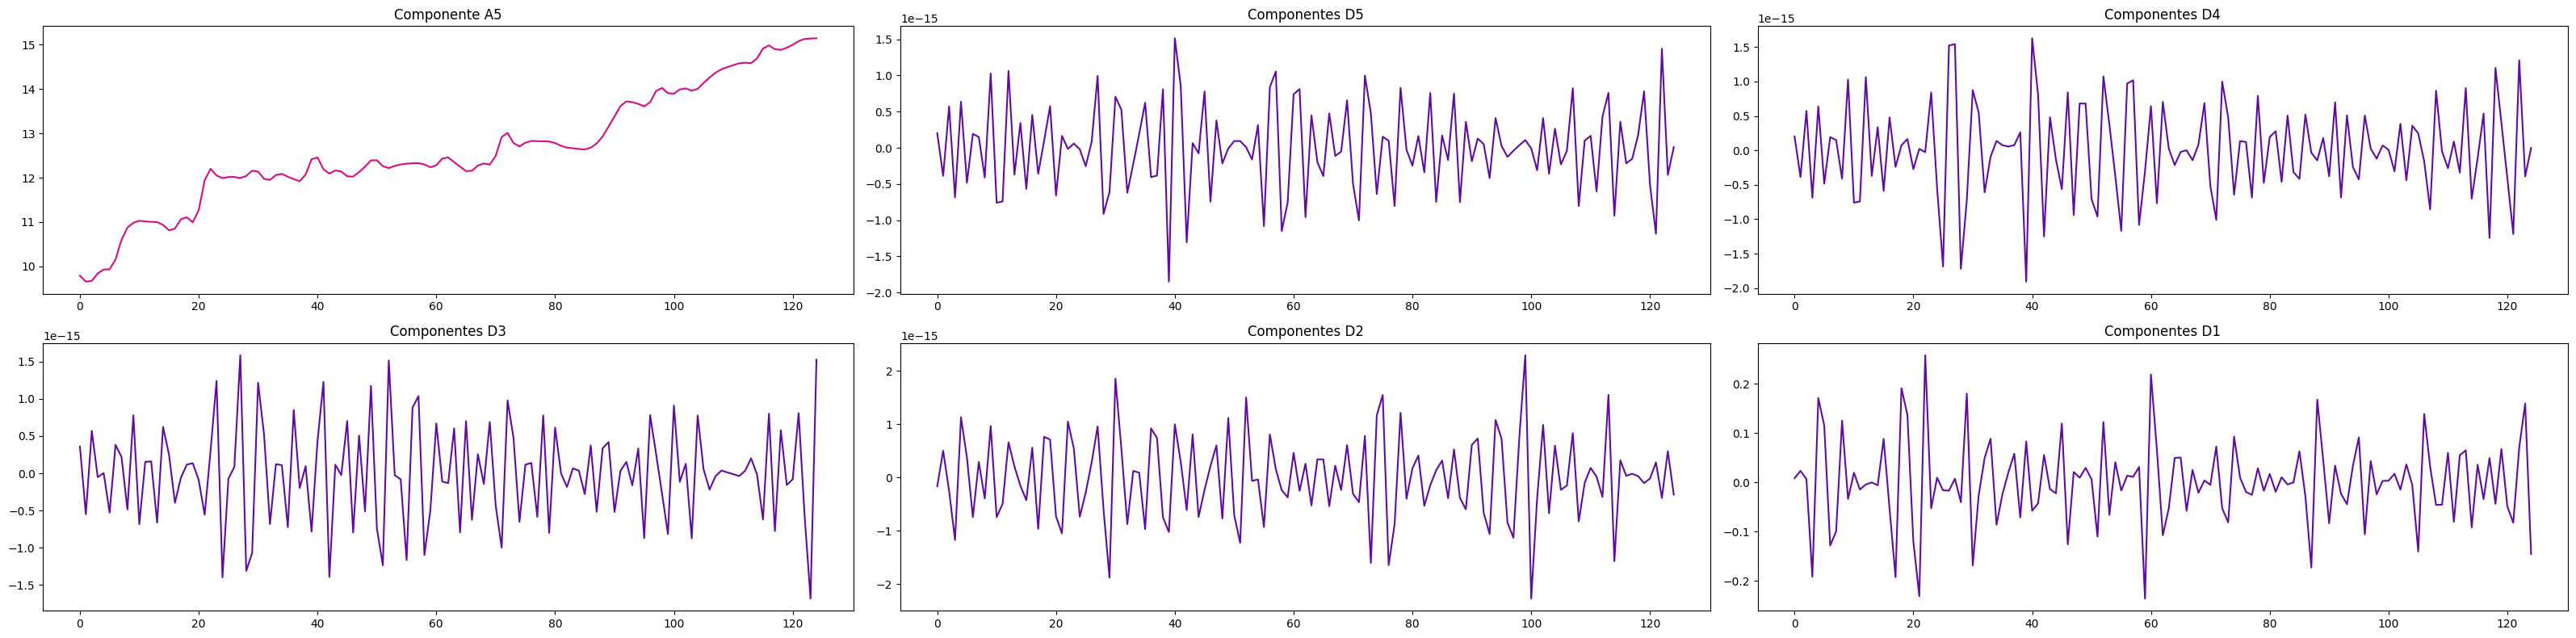

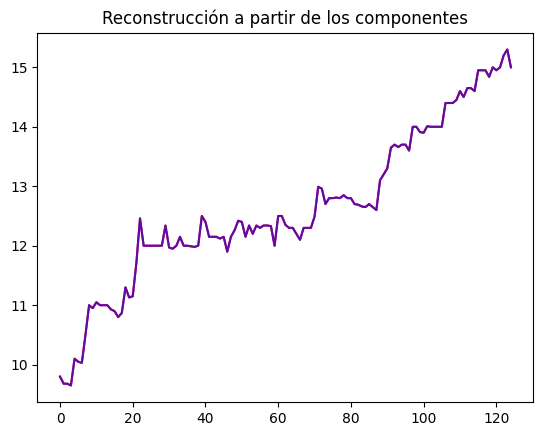

In [5]:
mode = 'symmetric'
components = m_dwt.multilevel_dwt(cierre, wavelet, 5, mode)
components_e = m_dwt.multilevel_dwt(cierre_e, wavelet, 5, mode) # componentes de entrenamiento 
components_p = m_dwt.multilevel_dwt(cierre_p, wavelet, 5, mode) #componentes de prueba

plt.figure(figsize=(32, 8))
aprox_coef = True
index = 1

c = 6

for _ in components_p:
    plt.subplot(2, 3, index)
    plt.plot(range(len(_)), _, color='#DA0C81' if aprox_coef else '#610C9F')
    plt.title('Componente A5' if aprox_coef else f'Componentes D{c}')
    aprox_coef = False
    index = index + 1
    c = c- 1

plt.tight_layout()
plt.show()

o_data = 0 #original data
for c in components_p:
    o_data =  o_data + c

plt.plot(range(len(o_data)),o_data, color='#DA0C81')
plt.plot(range(len(cierre_p)),o_data, color='#610C9F')
plt.title('Reconstrucción a partir de los componentes')
plt.show()

3. Normalizamos los componentes.

In [6]:
#Se normalizan cada uno de los elementos de los vectores contenidos en las descomposicion de la serie de tiempo original
components_e_n = [utls.normalizar(vect) for vect in components_e] # componentes de entrenamiento normalizados
components_p_n = [utls.normalizar(vect) for vect in components_p] # componentes de prueba normalizados len 78

#Se concatenan los ultimo 8 elementos del conjunto de entrenamiento para predecir el primero del conjunto de prueba
for i in range(len(components_p_n)):
    components_p[i] = np.concatenate((components_e[i][-8:],components_p[i]))
    components_p_n[i] = np.concatenate((components_e_n[i][-8:],components_p_n[i])) # len 86

#Estos 6 arreglos representan la descomposición de la señal original. Se tendrán que armar 6 redes que predigan cada una de estas
#componentes, Las entradas correspondientes a cada una son las 8 semanas anteriores para calcular la novena

4. Construimos seis LSTMnn para cada componente. El número de semanas anteriores que alimentaran a la red será de 8.

In [7]:
from src.modelos.recurrente.LSTM.LSTM import red_LSTM
from keras.utils import plot_model
#dejamos estos como ejemplo
#red_A5 = NARNN(input_dim=8, hidden_dim=0, output_dim=1, num_layers=0)

# Se carga la red LSTM que guardamos
networks = []
COMPONENTES = ['A5', 'D5', 'D4', 'D3', 'D2', 'D1']
time_steps = 8

for componente in COMPONENTES:
    red_C = red_LSTM(input_dim=8, output_dim=1)# ,name=f'red_LSTM_{componente}'
    red_C(np.ones((1, 8, 1)))  # el modelo es instanciado y llamado por primera vez
    if componente == 'A5':
        red_C.load_weights(f'redes/DWT_LSTM/estandar/ACTINVRB/finales/{componente}_lr0.001_e60_batch32.h5')
    if componente in ['D5', 'D4']:
        red_C.load_weights(f'redes/DWT_LSTM/estandar/ACTINVRB/finales/{componente}_lr0.01_e60_batch32.h5')
    if componente in ['D3', 'D2', 'D1']:
        red_C.load_weights(f'redes/DWT_LSTM/estandar/ACTINVRB/finales/{componente}_lr0.01_e90_batch32.h5')
    networks.append(red_C)
    
X_entrenamiento_n = [[],[],[],[],[],[]]
y_entrenamiento_n = [[],[],[],[],[],[]]

X_prueba_n = [[],[],[],[],[],[]]
y_prueba_n = [[],[],[],[],[],[]]

# A cada uno de los conjuntos de entrenamiento se les da una forma de entrada en especifico,
# que es un arreglo de 8 y uno de un solo elemento para representar la salida
for e in range(6):
    subarreglos = []
    for i in range(len(components_e_n[e])-8): #182-8
        # conjunto de entradas para el entrenamiento
        X_entrenamiento_n[e].append(components_e_n[e][i:i+8])
        # conjunto de salidas para el entrenamiento
        y_entrenamiento_n[e].append(components_e_n[e][i+8])
    for i in range(len(components_p_n[e])-8): #86-8
        # conjunto de entradas para la prueba
        X_prueba_n[e].append(components_p_n[e][i:i+8])
        # conjunto de salidas para la prueba
        y_prueba_n[e].append(components_p_n[e][i+8])

    #convertimos en un arreglo de numpy los conjuntos
    X_entrenamiento_n[e], y_entrenamiento_n[e] = np.array(X_entrenamiento_n[e]), np.array(y_entrenamiento_n[e])
    X_prueba_n[e], y_prueba_n[e] = np.array(X_prueba_n[e]), np.array(y_prueba_n[e])

    #Se le da una tercera dimension al conjunto de entradas de entrenamiento para poder darsela como parametro 
    #de entrada a la red
    X_entrenamiento_n[e] = np.reshape(X_entrenamiento_n[e], (X_entrenamiento_n[e].shape[0], X_entrenamiento_n[e].shape[1], 1))
    X_prueba_n[e] = np.reshape(X_prueba_n[e], (X_prueba_n[e].shape[0], X_prueba_n[e].shape[1], 1))

5. Entrenamos las 5 LSTMnn

# Entrenamiento estandar 

In [8]:
#Se define el número de epocas
# original 60/0.0001/32
EPOCAS = 90
LR=0.01
BS =32

In [9]:
from keras.optimizers import SGD
from keras.optimizers import Adam #¿Por qué con SGD no sirve?
from keras.callbacks import TensorBoard
import src.modelos.recurrente.entrenamientos.entrenamiento as entr
# entr.entrena_LM(networks[0],0,entrenamiento_8_1,EPOCAS,lr=0.01,λ =0.1)

# for i, model in enumerate(networks):
#     model.compile(optimizer=Adam(learning_rate=LR),loss='mean_squared_error')
#     history = model.fit(X_entrenamiento_n[i], y_entrenamiento_n[i], epochs=EPOCAS, batch_size=BS,
#                         callbacks=[entr.CalendarizadorPesos(logs_dir + f'/red_LSTM_{COMPONENTES[i]}'), 
#                                    entr.CalendarizadorPredicciones(logs_dir + f'/red_LSTM_{COMPONENTES[i]}', X_entrenamiento_n[i], y_entrenamiento_n[i]),
#                                    TensorBoard(log_dir=logs_dir + f'/red_LSTM_{COMPONENTES[i]}', histogram_freq=1)])
#     model.save_weights(f'redes/DWT_LSTM/estandar/ACTINVRB/{COMPONENTES[i]}_lr{LR}_e{EPOCAS}_batch{BS}.h5')

    

# Predicción del conjunto de entrenamiento
Usando los datos originales.

9/9 [==============================] - 2s 7ms/step


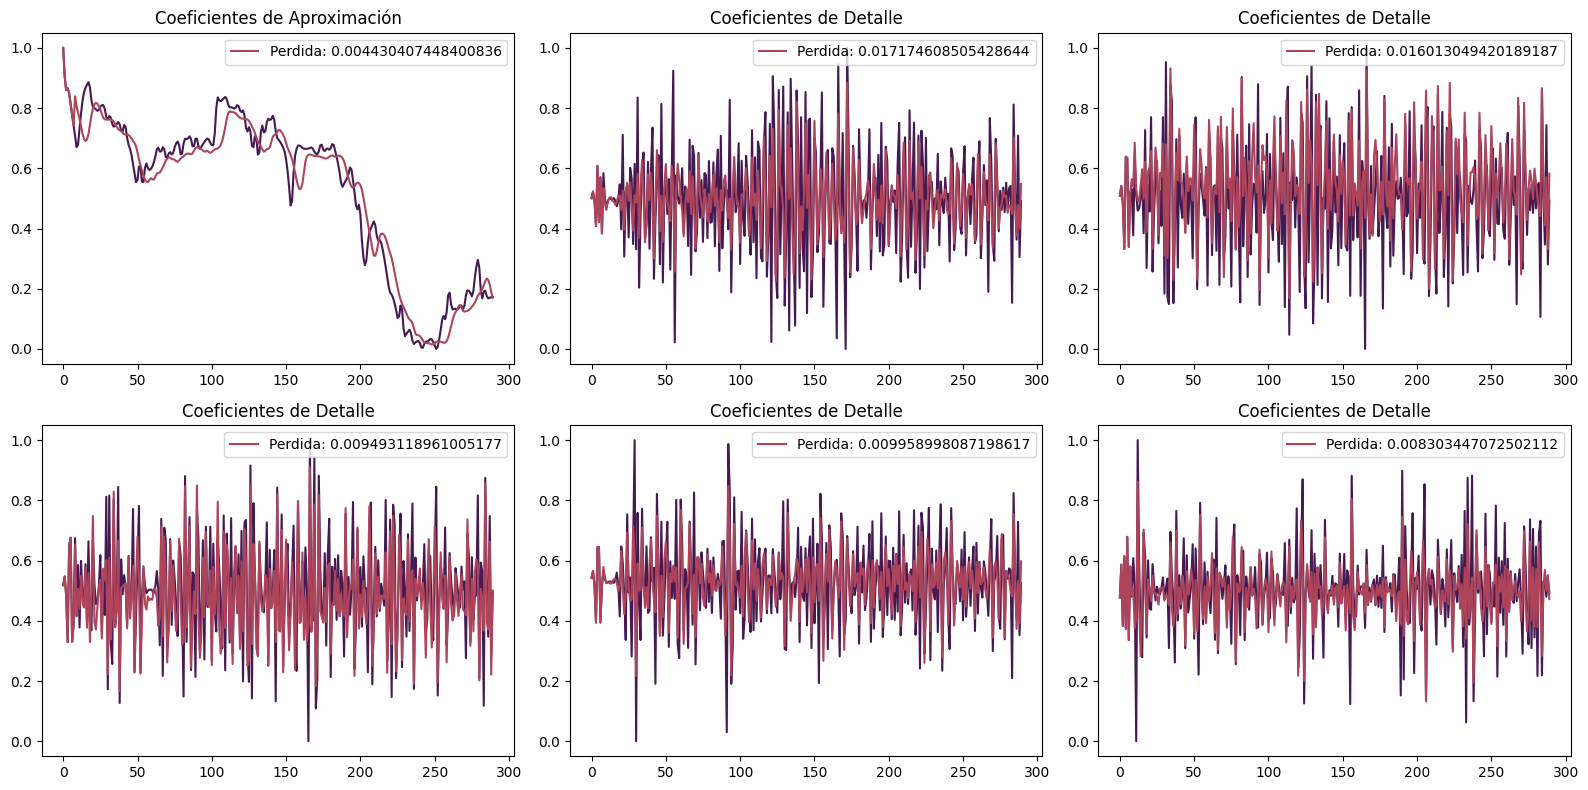

In [10]:
#Se grafica el conjunto de entrenamiento
perdidas = []
plt.figure(figsize=(16, 8))

aprox_coef = True
index = 1

for _ in range(len(components_e_n)):
    prediccion = networks[_].predict(X_entrenamiento_n[_])
    prediccion = np.reshape(prediccion, (prediccion.shape[0]))
    prediccion = np.concatenate((components_e_n[_][0:8], prediccion), axis=0) # se obtienen los primeros 8 datos
    perdidas.append(mean_squared_error(prediccion, components_e_n[_]))
    plt.subplot(2, 3, index)
    plt.plot(components_e_n[_], color = '#451952') #color='#DA0C81' if aprox_coef else '#610C9F')
    plt.plot(prediccion, label = f"Perdida: {float(perdidas[_])}", color='#AE445A')#label=f"Datos de Analisis: {DATOS}",
    plt.title('Coeficientes de Aproximación' if aprox_coef else 'Coeficientes de Detalle')
    aprox_coef = False
    plt.legend()
    index = index + 1

plt.tight_layout()
plt.show()


#print("Perdidas: " + str(perdidas))

# Predicción del conjunto de prueba

4/4 [==============================] - 0s 7ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


4/4 [==============================] - 0s 9ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


4/4 [==============================] - 0s 7ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


4/4 [==============================] - 0s 8ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


4/4 [==============================] - 0s 6ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


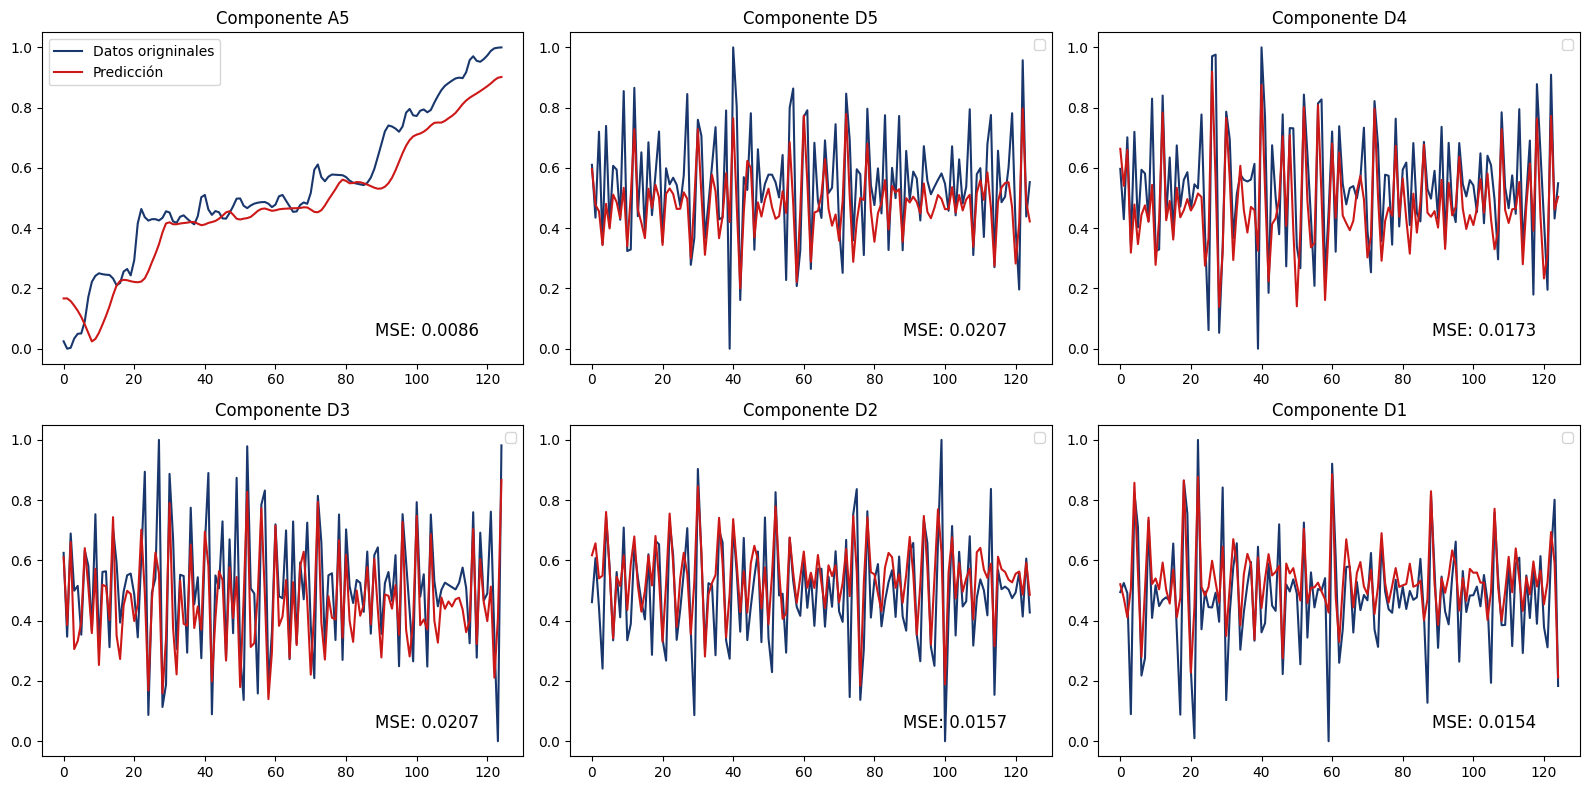

Perdidas: [<tf.Tensor: shape=(), dtype=float64, numpy=0.008126509640829832>, <tf.Tensor: shape=(), dtype=float64, numpy=0.019492414477794536>, <tf.Tensor: shape=(), dtype=float64, numpy=0.016274575481590753>, <tf.Tensor: shape=(), dtype=float64, numpy=0.019412541677868635>, <tf.Tensor: shape=(), dtype=float64, numpy=0.014779688240049754>, <tf.Tensor: shape=(), dtype=float64, numpy=0.014493215321337434>]


In [11]:
perdidas = []
predicciones = []
plt.figure(figsize=(16, 8))

aprox_coef = True
index = 1
c = 6

for _ in range(len(components_p_n)):
    prediccion = networks[_].predict(X_prueba_n[_])
    prediccion = np.reshape(prediccion, (prediccion.shape[0]))
    predicciones.append(np.concatenate((components_p_n[_][0:8], prediccion), axis=0)) # se obtienen los primeros 8 datos
    perdidas.append(mean_squared_error(predicciones[_], components_p_n[_]))
    plt.subplot(2, 3, index)
    
    plt.plot(components_p_n[_][8:], label= "Datos origninales" if aprox_coef else "", color = '#19376D') #color='#DA0C81' if aprox_coef else '#610C9F')
    plt.plot(predicciones[_][8:], label = "Predicción" if aprox_coef else "",color='#CD1818')#f"Perdida: {float(perdidas[_])}", label=f"Datos de Analisis: {DATOS}",#float(perdidas[_])
    
    plt.title('Componente A5' if aprox_coef else f'Componente D{c}')
    aprox_coef = False
    mse_e = mean_squared_error(np.reshape(predicciones[_][8:], (predicciones[_][8:].shape[0])), np.reshape(components_p_n[_][8:], (components_p_n[_][8:].shape[0])))
    plt.text(0.8, 0.1, f"MSE: {round(float(mse_e),4)}", fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)
    index = index + 1
    c = c - 1
    plt.legend()

plt.tight_layout()
plt.show()

print("Perdidas: " + str(perdidas))

# Reconstruimos la señal original
A partir de las predicciones y el conjunto de prueba.

In [12]:
#al conjunto de predicciones le quitamos los ultimos 8 elementos del conjunto de entrenamiento
for i in range(len(predicciones)):
    predicciones[i] = predicciones[i][8:]

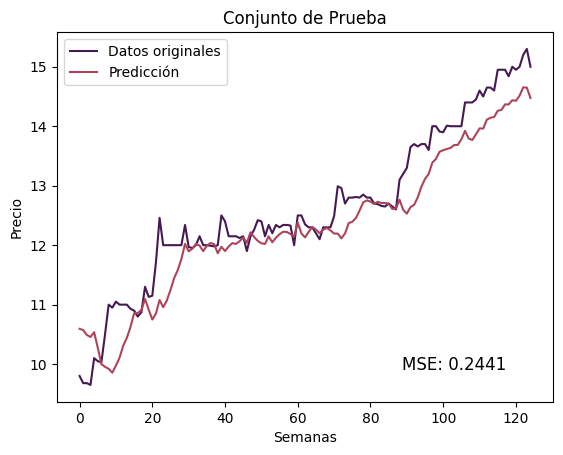

Perdida: 0.24407312353844968


In [13]:
predicciones_d = []
i=0
for vect in predicciones:
    # le quitamos los primeros time_steps elementos al conjunto: components_p[i][time_steps:]
    # para que no interfiera en la normalización
    predicciones_d.append(utls.desnormalizar(vect,np.max(components_p[i][8:]),np.min(components_p[i][8:])))
    i+=1

(A5_rec, D5_rec, D4_rec, D3_rec, D2_rec, D1_rec) = predicciones_d
rec = A5_rec + D5_rec + D4_rec + D3_rec + D2_rec + D1_rec

plt.plot(cierre_p, color = '#451952', label = 'Datos originales') #Señal original
plt.plot(rec, color='#AE445A', label = 'Predicción') #Señal predicha
plt.title('Conjunto de Prueba')
plt.xlabel('Semanas')
plt.ylabel('Precio')
mse_e = mean_squared_error(np.reshape(rec, (rec.shape[0])), np.reshape(cierre_p, (cierre_p.shape[0])))
plt.text(0.8, 0.1, f"MSE: {round(float(mse_e),4)}", fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)

plt.legend()
plt.show()

print(f"Perdida: {mean_squared_error(np.reshape(rec, (rec.shape[0])), np.reshape(cierre_p, (cierre_p.shape[0])))}")

plt.show()

# Evaluación de desempeño

In [14]:
#componentes desnormalizados contra predicciones desnormalizadas.
df_metricas = utls.genera_metricas(dict(zip(['c_prueba']+COMPONENTES,[cierre_p] + [c[time_steps:] for c in components_p])),
                                   dict(zip(['c_prueba']+COMPONENTES,[rec] + predicciones_d)))

# Mostramos el DataFrame con métricas
print(df_metricas) 

                              RMSE        MAPE    DS
Reconstrucción de c_prueba  0.4940    3.052687  71.2
Componente A5               0.5104    3.194822  50.4
Componente D5               0.0000   82.476074  77.6
Componente D4               0.0000   84.153618  80.8
Componente D3               0.0000   85.620667  76.0
Componente D2               0.0000   78.178528  80.0
Componente D1               0.0614  232.752878  76.0


# Entrenamiento auto-predictivo

In [15]:
# se cargan los pesos de los modelos
for i, model in enumerate(networks):
    model.load_weights(f'redes/DWT_LSTM/auto_predictiva/ACTINVRB/finales/{COMPONENTES[i]}_lr0.01_e60_bs8_df0.5.h5')

In [16]:
EPOCAS = 60
LR = 0.01
DF = 0.5
BS = 8

In [17]:
#entr.entrena_LM_pred(networks[0],0,entrenamiento_8_1,15 ,lr=0.5,λ =0.1,batch_size=8,decay_factor=5) #EPOCAS
#entr.cerrar_escritor()

# for i, model in enumerate(networks[3:]):
#     i=i+3
#     entr.entrena(model, np.reshape(components_e_n[i], (components_e_n[i].shape[0],1)), y_entrenamiento_n[i],
#                 8, epocas= EPOCAS, t_lote=BS, lr = LR, 
#                 callbacks=[entr.CalendarizadorTasaAprendizaje(log_dir=logs_dir_auto_pred+ f'/red_LSTM_{COMPONENTES[i]}',initial_lr=LR, decay_factor=DF,red = model),
#                            entr.CalendarizadorPesos(log_dir=logs_dir_auto_pred+ f'/red_LSTM_{COMPONENTES[i]}',e_predictivo=True,genera_histogramas=True,red = model)],
#                            log_dir=logs_dir_auto_pred+ f'/red_LSTM_{COMPONENTES[i]}')
#     # networks[i].save_weights(f'redes/DWT_LSTM/auto_predictiva/DWT_LSTM_{COMPONENTES[i]}.h5')
#     model.save_weights(f'redes/DWT_LSTM/auto_predictiva/ACTINVRB/{COMPONENTES[i]}_lr{LR}_e{EPOCAS}_bs{BS}_df{DF}.h5')

# Predicción del conjunto de prueba
Usando los datos que la red predice como entrada.

1/1 [==============================] - 0s 25ms/step


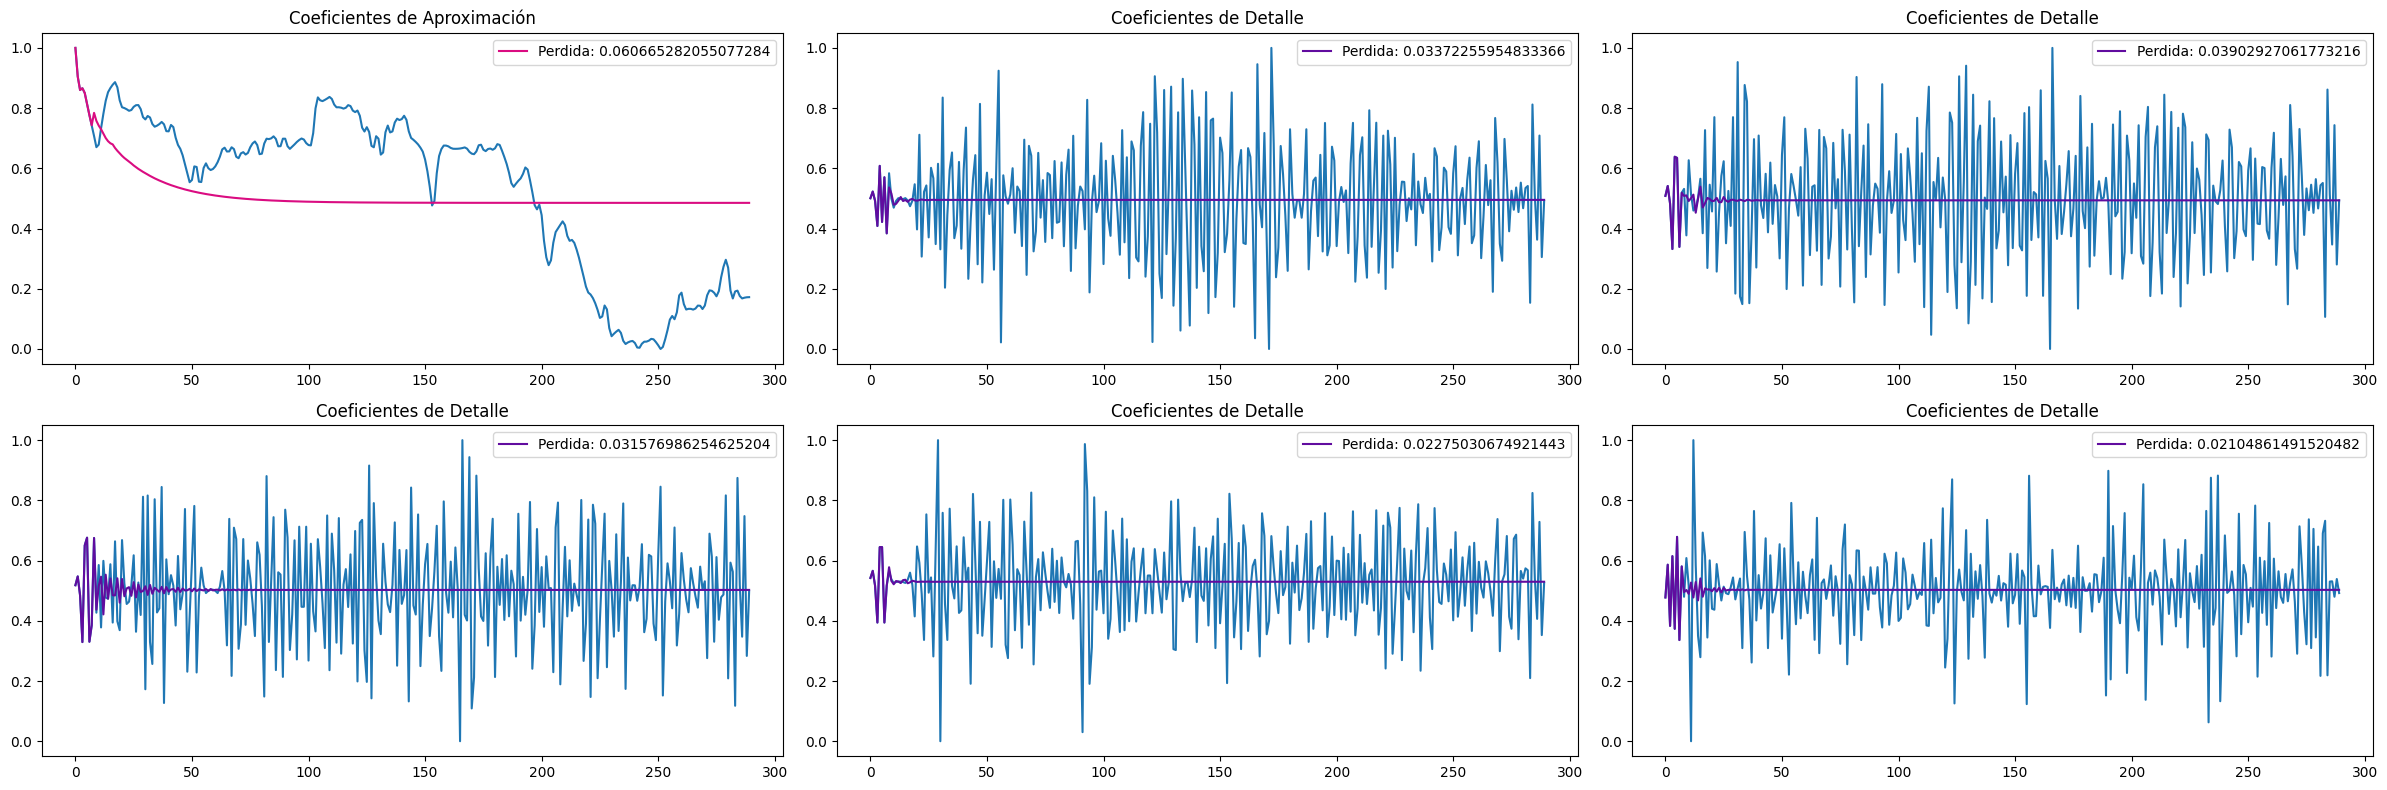

Perdidas predictivas: [<tf.Tensor: shape=(), dtype=float64, numpy=0.060665282055077284>, <tf.Tensor: shape=(), dtype=float64, numpy=0.03372255954833366>, <tf.Tensor: shape=(), dtype=float64, numpy=0.03902927061773216>, <tf.Tensor: shape=(), dtype=float64, numpy=0.031576986254625204>, <tf.Tensor: shape=(), dtype=float64, numpy=0.02275030674921443>, <tf.Tensor: shape=(), dtype=float64, numpy=0.02104861491520482>]


In [18]:
perdidas_predictivas = []
plt.figure(figsize=(24, 8))

aprox_coef = True
index = 1
predicciones = []

for _ in range(len(components_e_n)):
    predicciones.append(utls.genera_pred_auto_predictiva(components_e_n[_],time_steps,networks[_]))
    perdidas_predictivas.append(mean_squared_error(predicciones[_], components_e_n[_]))
    plt.subplot(2, 3, index)
    plt.plot(components_e_n[_])
    plt.plot(predicciones[_],  label = f"Perdida: {float(perdidas_predictivas[_])}", color='#DA0C81' if aprox_coef else '#610C9F')#float(perdidas_predictivas[_])
    plt.title('Coeficientes de Aproximación' if aprox_coef else 'Coeficientes de Detalle')
    aprox_coef = False
    plt.legend()
    index = index + 1

plt.tight_layout()
plt.show()

print("Perdidas predictivas: " + str(perdidas_predictivas))

1/1 [==============================] - 0s 21ms/step


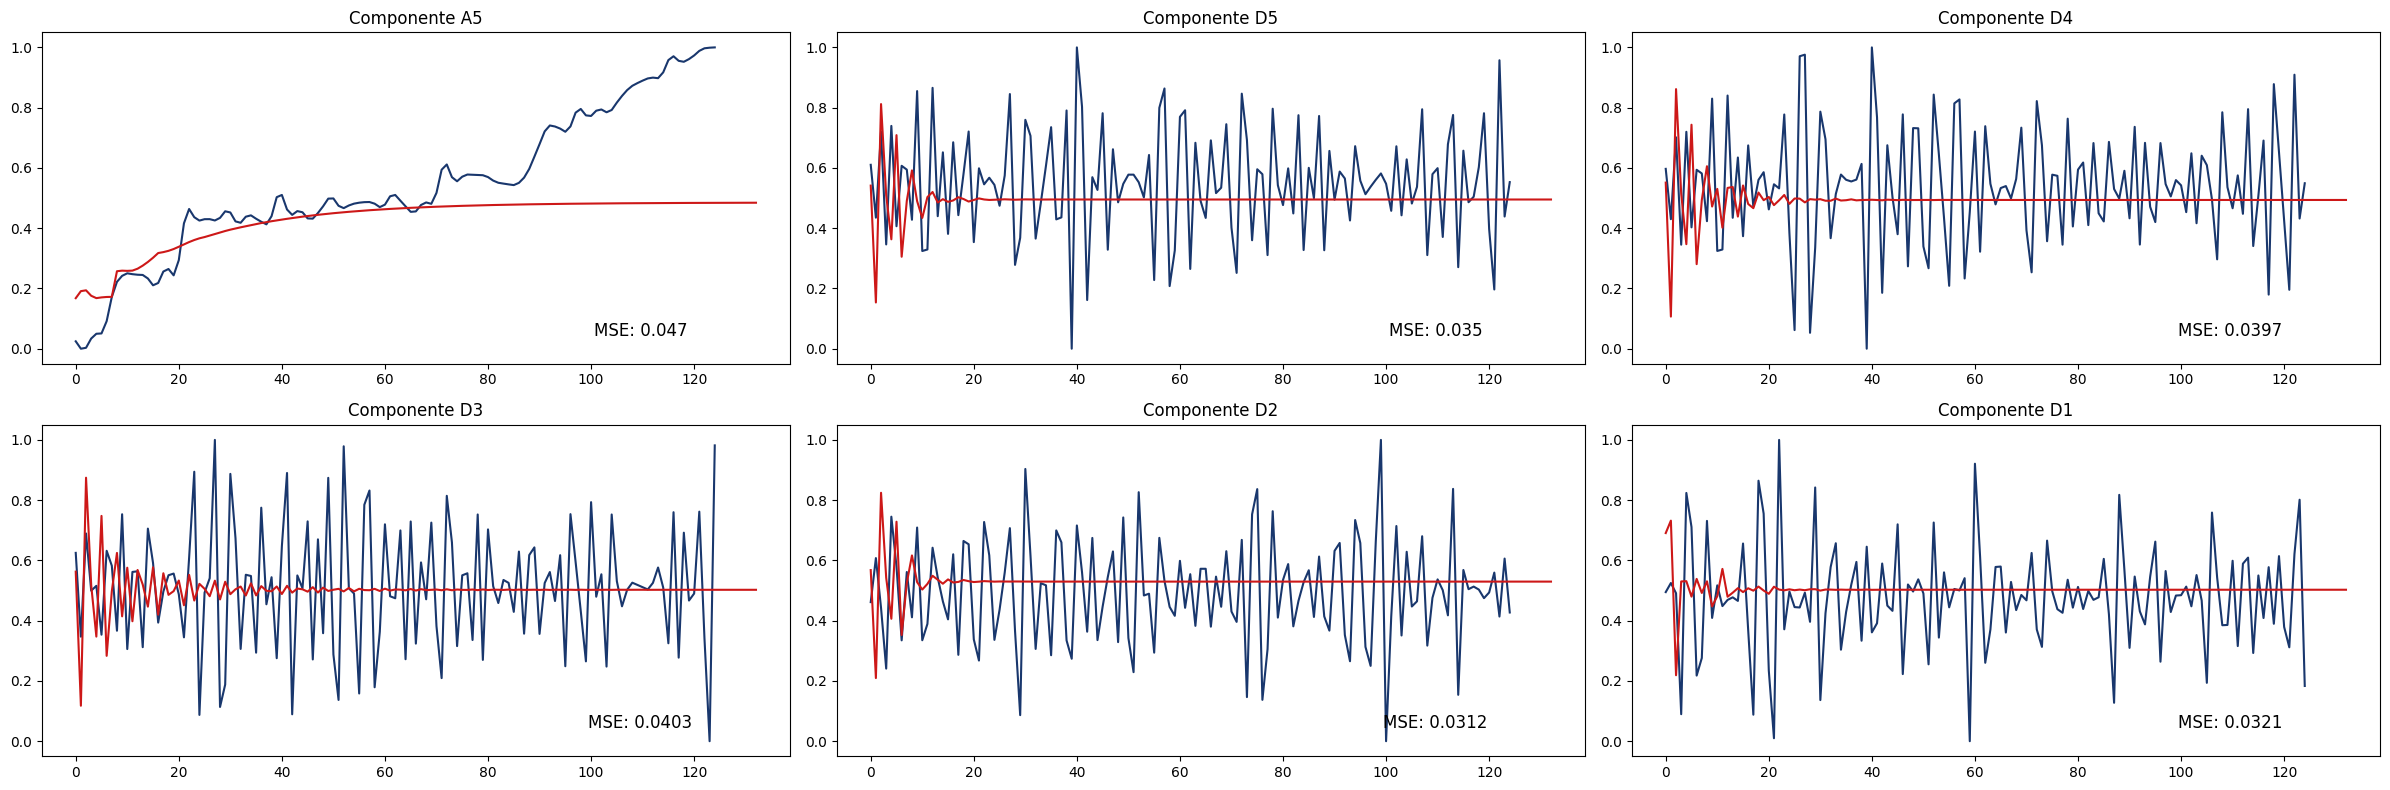

Perdidas predictivas: [<tf.Tensor: shape=(), dtype=float64, numpy=0.044172829010154756>, <tf.Tensor: shape=(), dtype=float64, numpy=0.03290644330354774>, <tf.Tensor: shape=(), dtype=float64, numpy=0.037321791957928625>, <tf.Tensor: shape=(), dtype=float64, numpy=0.037908795895509266>, <tf.Tensor: shape=(), dtype=float64, numpy=0.029312081238721876>, <tf.Tensor: shape=(), dtype=float64, numpy=0.03012915203689913>]


In [19]:
perdidas_predictivas = []
plt.figure(figsize=(24, 8))

aprox_coef = True
index = 1
predicciones = []
c=6

for _ in range(len(components_p_n)):
    predicciones.append(utls.genera_pred_auto_predictiva(components_p_n[_],time_steps,networks[_]))
    perdidas_predictivas.append(mean_squared_error(predicciones[_], components_p_n[_]))
    plt.subplot(2, 3, index)
    plt.plot(components_p_n[_][8:], color = '#19376D')
    plt.plot(predicciones[_],  color ='#CD1818') # label = f"Perdida: {float(perdidas_predictivas[_])}",
    plt.title('Componente A5' if aprox_coef else f'Componente D{c}')
    aprox_coef = False
    mse_e = mean_squared_error(np.reshape(predicciones[_][8:], (predicciones[_][8:].shape[0])), np.reshape(components_p_n[_][8:], (components_p_n[_][8:].shape[0])))
    plt.text(0.8, 0.1, f"MSE: {round(float(mse_e),4)}", fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)
    index = index + 1
    c=c-1

plt.tight_layout()
plt.show()

print("Perdidas predictivas: " + str(perdidas_predictivas))

# Reconstruimos la señal original
A partir de las predicciones y el conjunto de prueba.

In [20]:
#al conjunto de predicciones le quitamos los ultimos 8 elementos del conjunto de entrenamiento
for i in range(len(predicciones)):
    predicciones[i] = predicciones[i][8:]

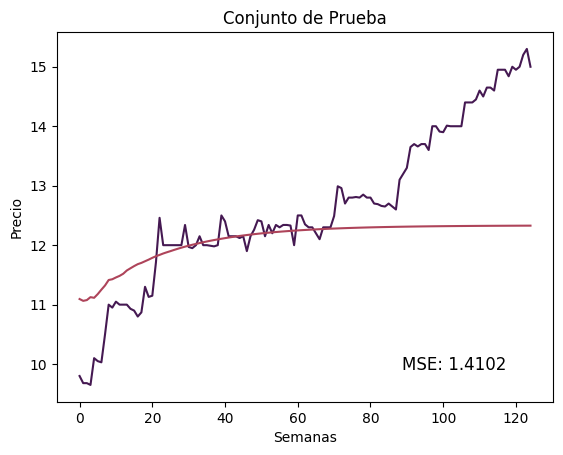

Perdida: 1.4101617221007592


In [21]:
predicciones_d = []
i=0
for vect in predicciones:
    # le quitamos los primeros time_steps elementos al conjunto: components_p[i][time_steps:]
    # para que no interfiera en la normalización
    predicciones_d.append(utls.desnormalizar(vect,np.max(components_p[i][time_steps:]),np.min(components_p[i][time_steps:])))
    i+=1

(A5_rec, D5_rec, D4_rec, D3_rec, D2_rec, D1_rec) = predicciones_d
rec = A5_rec + D5_rec + D4_rec + D3_rec + D2_rec + D1_rec

plt.plot(cierre_p, color = '#451952', label = 'Datos originales')
plt.plot(rec, color='#AE445A', label = 'Predicción')
plt.title('Conjunto de Prueba')
plt.xlabel('Semanas')
plt.ylabel('Precio')
mse_e = mean_squared_error(np.reshape(rec, (rec.shape[0])), np.reshape(cierre_p, (cierre_p.shape[0])))
plt.text(0.8, 0.1, f"MSE: {round(float(mse_e),4)}", fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

print(f"Perdida: {mean_squared_error(np.reshape(rec, (rec.shape[0])), np.reshape(cierre_p, (cierre_p.shape[0])))}")

# Evaluación de desempeño

In [22]:
df_metricas = utls.genera_metricas(dict(zip(['c_prueba']+COMPONENTES,[cierre_p] + [c[time_steps:] for c in components_p])),
                                   dict(zip(['c_prueba']+COMPONENTES,[rec] + predicciones_d)))

# Mostramos el DataFrame con métricas
print(df_metricas) 

                              RMSE        MAPE    DS
Reconstrucción de c_prueba  1.1875    6.243048  59.2
Componente A5               1.1900    6.227096  59.2
Componente D5               0.0000   94.481289  75.2
Componente D4               0.0000   92.125017  46.4
Componente D3               0.0000   79.400759  55.2
Componente D2               0.0000   96.781732  72.0
Componente D1               0.0885  193.398147  47.2


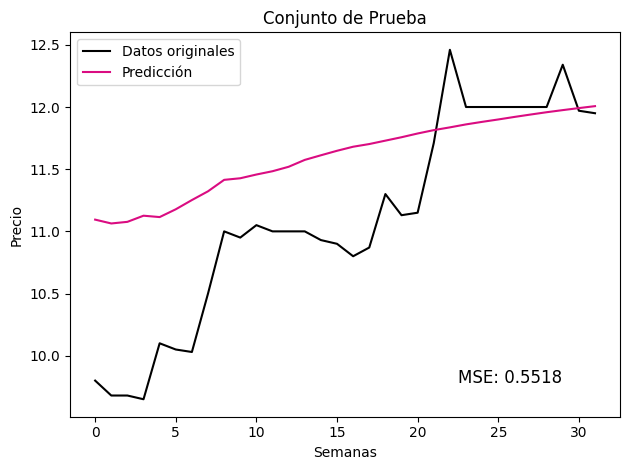

                              RMSE        MAPE      DS
Reconstrucción de c_prueba  0.7428    5.710421  56.250
Componente A5               0.7257    5.622024  56.250
Componente D5               0.0000   98.251057  56.250
Componente D4               0.0000   92.693344  31.250
Componente D3               0.0000   78.882280  53.125
Componente D2               0.0000  103.131896  46.875
Componente D1               0.1194  281.747058  34.375


In [23]:
cota_semanas = 32

plt.plot(cierre_p[:cota_semanas], color = 'black', label = 'Datos originales') #c_prueba_n
plt.plot(rec[:cota_semanas], color='#DA0C81', label = 'Predicción')
plt.title('Conjunto de Prueba')
plt.xlabel('Semanas')
plt.ylabel('Precio')
mse_e = mean_squared_error(np.reshape(rec[:cota_semanas], (rec[:cota_semanas].shape[0])), np.reshape(cierre_p[:cota_semanas], (cierre_p[:cota_semanas].shape[0])))
plt.text(0.8, 0.1, f"MSE: {round(float(mse_e),4)}", fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)
plt.legend()

plt.tight_layout()
plt.show()

df_metricas = utls.genera_metricas(dict(zip(['c_prueba']+COMPONENTES,[cierre_p] + [c[time_steps:] for c in components_p])),
                                   dict(zip(['c_prueba']+COMPONENTES,[rec] + predicciones_d)), cota=32)

# Mostramos el DataFrame con métricas
print(df_metricas) 

1/1 [==============================] - 0s 20ms/step


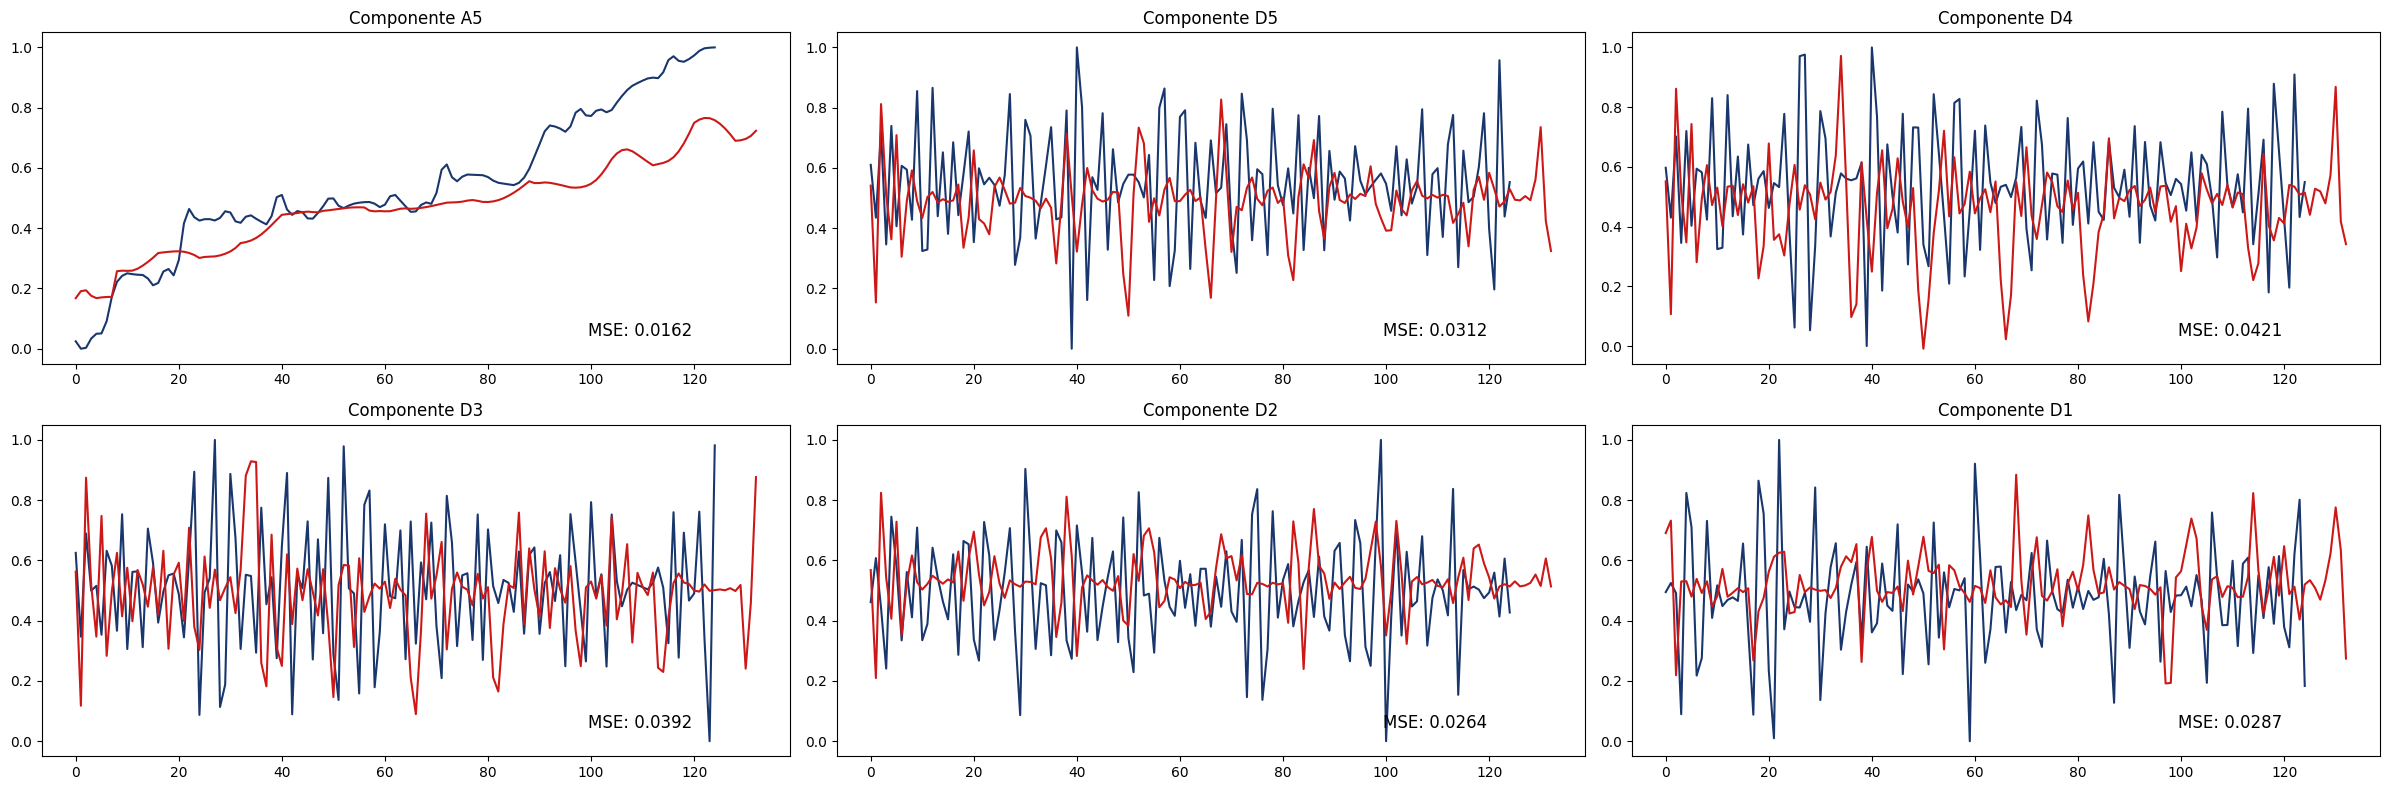

Perdidas predictivas: [<tf.Tensor: shape=(), dtype=float64, numpy=0.015191357092573856>, <tf.Tensor: shape=(), dtype=float64, numpy=0.029280636772271888>, <tf.Tensor: shape=(), dtype=float64, numpy=0.03955819006217495>, <tf.Tensor: shape=(), dtype=float64, numpy=0.036856185589709274>, <tf.Tensor: shape=(), dtype=float64, numpy=0.024783919239919995>, <tf.Tensor: shape=(), dtype=float64, numpy=0.02698840921427231>]


In [24]:
perdidas_predictivas = []
plt.figure(figsize=(24, 8))

aprox_coef = True
index = 1
predicciones = []
c=6

for _ in range(len(components_p_n)):
    predicciones.append(utls.genera_pred_auto_predictiva(components_p_n[_],time_steps,networks[_],correccion=True))
    perdidas_predictivas.append(mean_squared_error(predicciones[_], components_p_n[_]))
    plt.subplot(2, 3, index)
    plt.plot(components_p_n[_][8:], color = '#19376D')
    plt.plot(predicciones[_],  color ='#CD1818') # label = f"Perdida: {float(perdidas_predictivas[_])}",
    plt.title('Componente A5' if aprox_coef else f'Componente D{c}')
    aprox_coef = False
    mse_e = mean_squared_error(np.reshape(predicciones[_][8:], (predicciones[_][8:].shape[0])), np.reshape(components_p_n[_][8:], (components_p_n[_][8:].shape[0])))
    plt.text(0.8, 0.1, f"MSE: {round(float(mse_e),4)}", fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)
    index = index + 1
    c=c-1

plt.tight_layout()
plt.show()

print("Perdidas predictivas: " + str(perdidas_predictivas))

#al conjunto de predicciones le quitamos los ultimos 8 elementos del conjunto de entrenamiento
for i in range(len(predicciones)):
    predicciones[i] = predicciones[i][8:]

predicciones_d = []
i=0
for vect in predicciones:
    # le quitamos los primeros time_steps elementos al conjunto: components_p[i][time_steps:]
    # para que no interfiera en la normalización
    predicciones_d.append(utls.desnormalizar(vect,np.max(components_p[i][time_steps:]),np.min(components_p[i][time_steps:])))
    i+=1

(A5_rec, D5_rec, D4_rec, D3_rec, D2_rec, D1_rec) = predicciones_d
rec = A5_rec + D5_rec + D4_rec + D3_rec + D2_rec + D1_rec

#(A5_p_n, D5_p_n, D4_p_n, D3_p_n, D2_p_n, D1_p_n) = [c[8:] for c in components_p_n]
#cierre_p_n = A5_p_n + D5_p_n + D4_p_n + D3_p_n + D2_p_n + D1_p_n

cierre_p_n = utls.normalizar(cierre_p)
 # se toma el minimo y el maximo de cierre_p para que la proporcion quede igual
rec_n = utls.normalizar(rec,_min=np.min(cierre_p),_max=np.max(cierre_p))

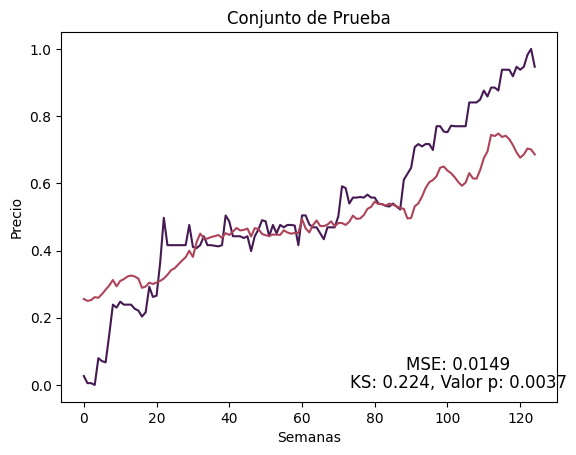

                              RMSE          MAPE    DS
Reconstrucción de c_prueba  0.1221  9.411952e+14  69.6
Componente A5               0.1271  9.333780e+14  51.2
Componente D5               0.1765  1.874865e+15  68.8
Componente D4               0.2052  1.433803e+15  68.0
Componente D3               0.1980  1.652462e+15  66.4
Componente D2               0.1624  1.896896e+15  69.6
Componente D1               0.1695  1.605032e+15  60.8


In [25]:
plt.plot(cierre_p_n, color = '#451952', label = 'Datos originales')
plt.plot(rec_n, color='#AE445A', label = 'Predicción')
plt.title('Conjunto de Prueba')
plt.xlabel('Semanas')
plt.ylabel('Precio')
mse_e = mean_squared_error(np.reshape(rec_n, (rec_n.shape[0])), np.reshape(cierre_p_n, (cierre_p.shape[0])))
ks_statistic, ks_p_value = ks_2samp(rec_n, cierre_p_n)
plt.text(0.8, 0.1, f"MSE: {round(float(mse_e),4)}", fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)
plt.text(0.8, 0.05, f"KS: {round(ks_statistic,4)}, Valor p: {round(ks_p_value,4)}", fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

#omitimos los primeros 8 datos (ultimos 8 del conjunto de entrenamiento) que agregamos en un inicio
df_metricas = utls.genera_metricas(dict(zip(['c_prueba']+COMPONENTES,[cierre_p_n] + [c[time_steps:] for c in components_p_n])),
                                   dict(zip(['c_prueba']+COMPONENTES,[rec_n] + predicciones)))

# Mostramos el DataFrame con métricas
print(df_metricas)